In [1]:
import cv2
import fingerprint_enhancer
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import hashlib
import random
import pyDHE
from Crypto.Random.random import randint
import pyaes, pbkdf2, binascii, os, secrets


import fingerprint_feature_extractor
import numpy as np
from PIL import Image
%matplotlib inline

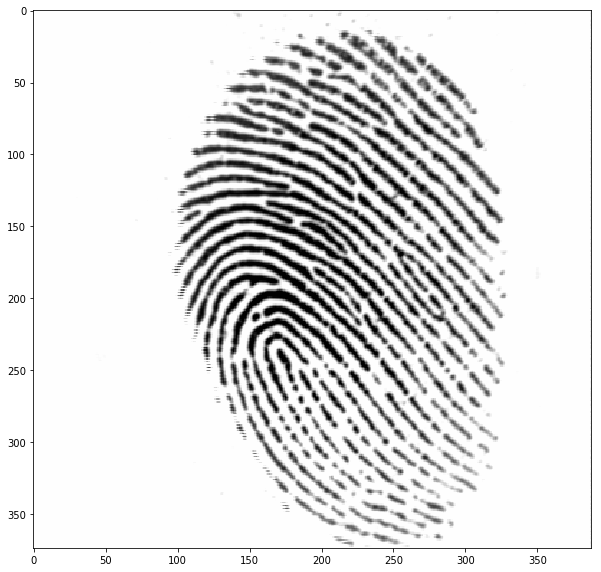

In [2]:
img = cv2.imread("data/DB1_B/101_1.tif", 0)
plt.figure(figsize = (10,10))
imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

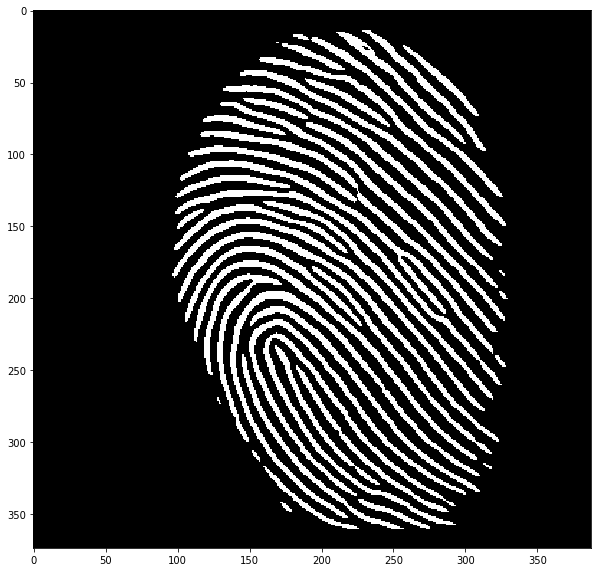

In [3]:
out = fingerprint_enhancer.enhance_Fingerprint(img)
plt.figure(figsize = (10,10))
imgplot = plt.imshow(out, cmap='gray', vmin=0, vmax=255)

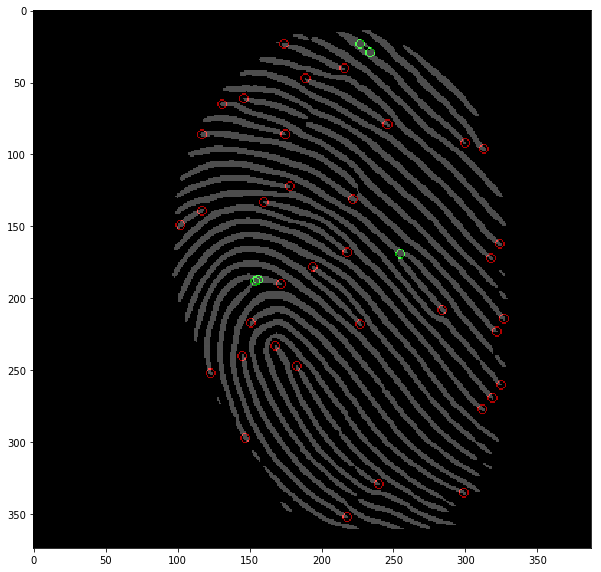

In [4]:
FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(out, showResult=False)

skel = []
img = np.uint8(img > 128)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel) * 255
mask = img * 255

(rows, cols) = skel.shape
DispImg = np.zeros((rows, cols, 3), np.uint8)
DispImg[:, :, 0] = 255*skel
DispImg[:, :, 1] = 255*skel
DispImg[:, :, 2] = 255*skel

for idx, curr_minutiae in enumerate(FeaturesTerminations):
    row, col = curr_minutiae.locX, curr_minutiae.locY
    (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
    skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

for idx, curr_minutiae in enumerate(FeaturesBifurcations):
    row, col = curr_minutiae.locX, curr_minutiae.locY
    (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
    skimage.draw.set_color(DispImg, (rr, cc), (0, 255, 0))

plt.figure(figsize = (10,10))
plt.imshow(out, cmap='gray', vmin=0, vmax=255)
plt.imshow(DispImg, alpha=0.7)


In [5]:
def pairs_to_binary(set):
    bins = np.histogram(set, bins=31)[1]        # 31 bins because we want to achieve a 5 bits representation
    quantized_values = np.digitize(set, bins) - 1

    binary_values = []
    for i in range(len(quantized_values)):
        bin = np.binary_repr(quantized_values[i], width=5)
        binary_values.append(bin)

    return binary_values
    
x_set = []
y_set = []
phi_set = []

for j in range(len(FeaturesTerminations)):
    x, y, phi = FeaturesTerminations[j].locX, FeaturesTerminations[j].locY, np.radians(
        FeaturesTerminations[j].Orientation[0])
    x_set.append(float(x))
    y_set.append(float(y))
    phi_set.append(float(phi))

l_set = []
alpha_set = []
beta_set = []

for i in range(len(x_set) - 1):
    for j in range(i + 1, len(x_set)):
        x1 = x_set[i]
        x2 = x_set[j]

        y1 = y_set[i]
        y2 = y_set[j]

        phi1 = phi_set[i]
        phi2 = phi_set[j]

        x = (x2 - x1) * np.cos(phi1) - (y2 - y1) * np.sin(phi1)
        y = (x2 - x1) * np.sin(phi1) - (y2 - y1) * np.cos(phi1)

        l = np.sqrt(np.square(x) + np.square(y))
        if x == 0:
            continue
        alpha1 = np.arctan(y / x)
        beta2 = alpha1 + phi2 - phi1

        l_set.append(l)
        alpha_set.append(alpha1)
        beta_set.append(beta2)

l_set_bin = pairs_to_binary(l_set)
alpha_set_bin = pairs_to_binary(alpha_set)
beta_set_bin = pairs_to_binary(beta_set)

feature_vector = np.zeros(np.power(2, 15), dtype=int)
for i in range(len(l_set_bin)):
    bin = int(l_set_bin[i] + alpha_set_bin[i] + beta_set_bin[i], 2)
    feature_vector[bin] = 1

number_of_features = sum(feature_vector)

In [6]:
print("".join(map(str, feature_vector)))

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000011001001010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000001000000000000000000000000000000010000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000100000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [7]:
# revocable transformation
transformation = list(range(len(feature_vector)))
random.shuffle(transformation)

shuffled_list = np.zeros(len(feature_vector), dtype=np.float64)

for i in range(len(shuffled_list)):
    shuffled_list[i] = feature_vector[transformation[i]]

print("".join(map(str, list(map(int, shuffled_list)))))


0000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000001000000000000010000000000000000000000000010000000000000000000000000000000000000000000001000000000000000000000000000000010000000000000000000010000000000000000000000000000000000000000000000000000000000110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000100000000000000000000000000000000000

In [8]:
h = hashlib.sha256()
h.update("".join(map(str, shuffled_list)).encode('utf-8'))
private_key = h.hexdigest()
print(private_key)

69d08575e59617f26f96b261e348836e1db4b7acaefefc438e788f536ebc40bf


In [30]:
# Diffie-Hellman

prime = 0xFFFFFFFFFFFFFFFFC90FDAA22168C234C4C6628B80DC1CD129024E088A67CC74020BBEA63B139B22514A08798E3404DDEF9519B3CD3A431B302B0A6DF25F14374FE1356D6D51C245E485B576625E7EC6F44C42E9A637ED6B0BFF5CB6F406B7EDEE386BFB5A899FA5AE9F24117C4B1FE649286651ECE45B3DC2007CB8A163BF0598DA48361C55D39A69163FA8FD24CF5F83655D23DCA3AD961C62F356208552BB9ED529077096966D670C354E4ABC9804F1746C08CA18217C32905E462E36CE3BE39E772C180E86039B2783A2EC07A28FB5C55DF06F4C52C9DE2BCBF6955817183995497CEA956AE515D2261898FA051015728E5A8AAAC42DAD33170D04507A33A85521ABDF1CBA64ECFB850458DBEF0A8AEA71575D060C7DB3970F85A6E1E4C7ABF5AE8CDB0933D71E8C94E04A25619DCEE3D2261AD2EE6BF12FFA06D98A0864D87602733EC86A64521F2B18177B200CBBE117577A615D6C770988C0BAD946E208E24FA074E5AB3143DB5BFCE0FD108E4B82D120A92108011A723C12A787E6D788719A10BDBA5B2699C327186AF4E23C1A946834B6150BDA2583E9CA2AD44CE8DBBBC2DB04DE8EF92E8EFC141FBECAA6287C59474E6BC05D99B2964FA090C3A2233BA186515BE7ED1F612970CEE2D7AFB81BDD762170481CD0069127D5B05AA993B4EA988D8FDDC186FFB7DC90A6C08F4DF435C93402849236C3FAB4D27C7026C1D4DCB2602646DEC9751E763DBA37BDF8FF9406AD9E530EE5DB382F413001AEB06A53ED9027D831179727B0865A8918DA3EDBEBCF9B14ED44CE6CBACED4BB1BDB7F1447E6CC254B332051512BD7AF426FB8F401378CD2BF5983CA01C64B92ECF032EA15D1721D03F482D7CE6E74FEF6D55E702F46980C82B5A84031900B1C9E59E7C97FBEC7E8F323A97A7E36CC88BE0F1D45B7FF585AC54BD407B22B4154AACC8F6D7EBF48E1D814CC5ED20F8037E0A79715EEF29BE32806A1D58BB7C5DA76F550AA3D8A1FBFF0EB19CCB1A313D55CDA56C9EC2EF29632387FE8D76E3C0468043E8F663F4860EE12BF2D5B0B7474D6E694F91E6DBE115974A3926F12FEE5E438777CB6A932DF8CD8BEC4D073B931BA3BC832B68D9DD300741FA7BF8AFC47ED2576F6936BA424663AAB639C5AE4F5683423B4742BF1C978238F16CBE39D652DE3FDB8BEFC848AD922222E04A4037C0713EB57A81A23F0C73473FC646CEA306B4BCBC8862F8385DDFA9D4B7FA2C087E879683303ED5BDD3A062B3CF5B3A278A66D2A13F83F44F82DDF310EE074AB6A364597E899A0255DC164F31CC50846851DF9AB48195DED7EA1B1D510BD7EE74D73FAF36BC31ECFA268359046F4EB879F924009438B481C6CD7889A002ED5EE382BC9190DA6FC026E479558E4475677E9AA9E3050E2765694DFC81F56E880B96E7160C980DD98EDD3DFFFFFFFFFFFFFFFFF
generator = 2

public_key = pow(generator, int(private_key, 16), prime)

print(hex(public_key))

0x76c298d1f3e3e661268f64e6ca94939e27865f4c8c984afa2896ce634696341a4a60b98be9d42f006586e6d891f76dc5772fde03112a4785eff03f1ec159d0ebd197a41ae6c1229f3d1d20830b0950ca0535ebfae41be511df52c6f522250290f0c29ceb0546fc46cdcd3d2de994520d63c830c184685292f343bded3571efc9210bb02c9d68ecaa13f4319d25ae1ab712b881c6b6d9a710b5a3a11c45cc46bdacb4df1daca5daee3df6e7b96f67cbc8984fc6c17744b0334bb94ff20ad51f134844934f520781e8b4ea2ef7612041e772bf930429fcd36ed18426ba43fe4dde2725e79746a35bdccea6151f326101ed99d6be04fde98796cd0520bd4eefbec0506dba1de010b74177a5bdf0b2e584f34b0aee9f15e29fea5ed54851e0584f542465bad53203265e6de37a05d59cc1ef2f6a6f319d88a4c74f5a68893257026d1e09911ee59b230006b1c572e99632adf56bba984f2d3e22aff89b55e7de4709742fdf0d6056ea697cc97309af9e94d1a109678c7c8e6e8a5692e3e262badf5b65c8f282cd006b69fc07ab26dc9342b262a387f58032a8d598e17a015ed0f40d4ab3125152688bf0d534fc4ee23bcc5286e0e8e91fa69af476f7adf1c99d09014f03a3703a576f45e0f37abbdffe4a7f0218a90a28515a53b68beacefb64955daf6596e9c8eb3cf8add217021c18dbc288b6db

In [29]:
# generating another private/public key

private_key_2 = randint(1, prime - 1)
public_key_2 = pow(generator, private_key_2, prime)

key_1 = pow(public_key_2, int(private_key, 16), prime)
key_2 = pow(public_key, private_key_2, prime)

In [31]:
h = hashlib.sha256()
h.update(f'0b{key_1:08b}'[2:].encode('utf8'))
key_1_h = h.hexdigest()
h = hashlib.sha256()
h.update(f'0b{key_2:08b}'[2:].encode('utf8'))
key_2_h = h.hexdigest()
print(key_1_h)
print(key_2_h)

print("\nTest to see if the hashed keys are the same:")
print(key_1_h == key_2_h)

d08da2238d39bec95a9af0a52ada01b846194a08aeafb228b60682aa2bd5e87c
d08da2238d39bec95a9af0a52ada01b846194a08aeafb228b60682aa2bd5e87c

Test to see if the hashed keys are the same:
True


In [25]:
# Encrypt the plaintext with the given key:
#   ciphertext = AES-256-CTR-Encrypt(plaintext, key, iv)
key_1 = pbkdf2.PBKDF2(key_1_h, "1").read(32)
key_2 = pbkdf2.PBKDF2(key_2_h, "1").read(32)

iv = secrets.randbits(64)
plaintext = "Text for encryption"

aes = pyaes.AESModeOfOperationCTR(key_1, pyaes.Counter(iv))
ciphertext = aes.encrypt(plaintext)
print('Encrypted:', binascii.hexlify(ciphertext))

Encrypted: b'276990805f4735fdc3d7a435e9c2e718f72fe4'
